# Grad CAM exploration

We are modifying the lesson 1 notebook to see if we can implement [Grad-CAM](https://arxiv.org/abs/1610.02391). The idea is to obtain a heatmap of the important areas of the images for the classifier.

The objective is to eventually use this for the satellite project.

In [1]:
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
import re
import scipy.ndimage
%matplotlib inline

In [3]:
import fastai
fastai.__version__

'1.0.42'

## Setup
We start by doing the same as in lesson 1 to setup our model.

In [4]:
torch.cuda.set_device(0)

In [5]:
path = untar_data(URLs.PETS); path
bs =64

In [6]:
path_anno = path/'annotations'
path_img = path/'images'

In [7]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/home/henripal/.fastai/data/oxford-iiit-pet/images/boxer_28.jpg'),
 PosixPath('/home/henripal/.fastai/data/oxford-iiit-pet/images/miniature_pinscher_148.jpg'),
 PosixPath('/home/henripal/.fastai/data/oxford-iiit-pet/images/pug_203.jpg'),
 PosixPath('/home/henripal/.fastai/data/oxford-iiit-pet/images/german_shorthaired_21.jpg'),
 PosixPath('/home/henripal/.fastai/data/oxford-iiit-pet/images/beagle_157.jpg')]

In [8]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [9]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

In [10]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

In [11]:
learn.fit_one_cycle(4)

Total time: 02:06
epoch  train_loss  valid_loss  error_rate
1      0.683224    0.275337    0.092693    (00:24)
2      0.377490    0.240959    0.073748    (00:22)
3      0.223942    0.193579    0.062246    (00:58)
4      0.157170    0.176225    0.062246    (00:22)



In [12]:
learn.save('example-dogscats')

## Grad Cam Setup

See [this paper](https://arxiv.org/abs/1610.02391) for details. The idea is to take the outputs of the last "convolutional layer", here a stack of 7x7 feature maps, then weigh them by their importance to the given class using an average of the gradients of those layers wrt the class score vector.

We therefore need to set up two hooks:
- for the feature maps
- for the gradient

Then we linearly combine the feature maps using a reduced version of the gradient to obtain the heatmap.

In [13]:
# we are going to use the output of the last Bottleneck as feature maps
# this is hardcoded for resnet50
target_layer = learn.model[0][7][2]
target_layer

Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
)

In [14]:
# hook for the feature maps

fmap_hook = fastai.callbacks.hook_output(target_layer)

In [15]:
# hook for the gradients 
def gradient_torch_hook(self, grad_input, grad_output):
    return grad_input

gradient_hook = fastai.callbacks.Hook(target_layer, gradient_torch_hook, is_forward=False)

## Grad Cam

Our hooks are setup, let's run the forward and backward passes to get what we need.

In [16]:
# we start by extracting a batch then choosing one image and label from that batch
# i is the index of the chosen image
i = 13
image_batch, label_batch = next(iter(learn.data.train_dl))
image = image_batch[i].reshape(1, 3, 224, 224)
label = label_batch[i].reshape(-1)

In [17]:
learn.model.eval();

In [18]:
# running the forward pass
learn.model.zero_grad();
out = learn.model(image)

# we need to set the gradients at the output to ones at the predicted class
# and zero everywere else
onehot = torch.zeros(learn.data.c)
onehot[torch.argmax(out)] = 1.0

# we then backprop from there
out.backward(gradient=onehot.reshape(1, -1).cuda(), retain_graph=True)

In [19]:
gradients = next(iter(gradient_hook.stored))
gradients.shape

torch.Size([1, 2048, 7, 7])

We've now run our forward and backward passes, we only need to combine the gradients and feature maps to obtain our heat map

In [20]:
gradient_linearization = gradients.cpu().numpy().sum((2, 3)).reshape(-1)
fmaps = fmap_hook.stored.cpu().numpy()
print(fmaps.shape)
fmaps = fmaps.reshape(2048, 7, 7)

(1, 2048, 7, 7)


In [21]:
# relu on the heatmap
heatmap = np.maximum(0, np.einsum('i, ijk',gradient_linearization, fmaps))

# we now upsample the heatmap so we can overlay it on our original image
upsampled = scipy.ndimage.zoom(heatmap, 32)
upsampled = (upsampled - np.min(upsampled))/(np.max(upsampled) - np.min(upsampled))

In [22]:
def image_from_tensor(imagetensor):
    numpied = torch.squeeze(imagetensor)
    numpied = np.moveaxis(numpied.cpu().numpy(), 0 , -1)
    numpied = numpied - np.min(numpied)
    numpied = numpied/np.max(numpied)
    return numpied

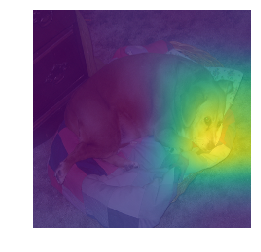

In [23]:
plt.imshow(image_from_tensor(image))
plt.imshow(upsampled, alpha=.8)
plt.gca().set_axis_off()

## Guided Backprop

So, our heatmap above is nice but unfortunately not very fine-grained. We are constrained by the resolution of the feature maps (in our example 7x7).

A first idea would be to naively compute the backprop the gradients of our "forced score" all the way to the image, and see which pixel has higher gradients. So let's do that:

In [24]:
# we ask the model to compute the gradients wrt the image:
image.requires_grad_()

# and then perform our forward and backward passes, forcing the gradient to be 1 for our predicted class
out = learn.model(image)
out.backward(gradient=onehot.reshape(1, -1).cuda())

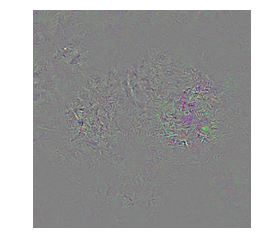

In [25]:
plt.imshow(image_from_tensor(image.grad))
plt.gca().set_axis_off()

That looks horrifying. This because the various neurons [interfere](https://en.wikipedia.org/wiki/Wave_interference) with each other during the backpropagation.

The [Strving for Simplicity: the All Convolutional Net paper](https://arxiv.org/abs/1412.6806) introduced the concept of _Guided Backpropagation_. The idea, to avoid interference is to simply retain the _positive_ contributions to the gradient while back-propaagating, thereby avoiding all interference.

The idea is to clip all negative gradients at each ReLU layer. We will do this using the Hooks module in the fastai library

In [26]:
## this callback will make all gradients positive during backprop
def clamp_gradients_hook(module, grad_in, grad_out):
    for grad in grad_in:
        torch.clamp_(grad, min=0.0)

In [27]:
## we inventory all Relu Modules
relu_modules = [module[1] for module in learn.model.named_modules() if str(module[1]) == "ReLU(inplace)"]
len(relu_modules)

18

In [28]:
## and register our hooks with fastai
hooks = fastai.callbacks.Hooks(relu_modules, clamp_gradients_hook, is_forward=False)

Our hooks are registered, we will now backprop and observe the result:

In [29]:
learn.model.eval()
image.requires_grad_()
learn.model.zero_grad()
out = learn.model(image)

In [30]:
out.backward(gradient=onehot.reshape(1, -1).cuda(), retain_graph=True)

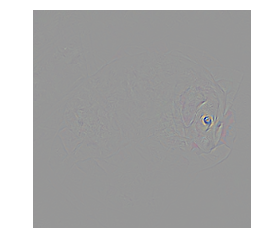

In [31]:
plt.imshow(image_from_tensor(image.grad))
plt.gca().set_axis_off()

To make sure we are only looking at relevant areas of the image, we will multiply this by the heatmap computed using Grad CAM:

In [32]:
gbp =  image_from_tensor(image.grad)

In [33]:
prod = np.einsum('ijk, ij->ijk',gbp, upsampled)

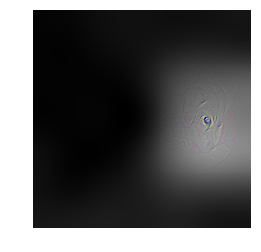

In [34]:
plt.imshow(prod)
plt.gca().set_axis_off()

yay!